In [1]:
import sys, os, re, gzip, json, pickle, shutil, random

import numpy as np
import sklearn
import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False

In [2]:
#!{sys.executable} -m pip install librosa
#!{sys.executable} -m pip install pydub

In [3]:
from pydub.utils import mediainfo
from pydub import AudioSegment

import librosa
import librosa.display

import soundfile as sf

In [4]:
data_path = '../data'
myspace_mp3s_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_mp3s_path
genre_map_path = '%s/genre_map.pkl' % myspace_mp3s_path

features_path = '%s/audio_features' % data_path

### General helper methods

In [5]:
def load_metadata(metadata_path):
    with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
        metadata = json.load(fz)
    return metadata


def load_genre_map(genre_map_path):
    with open(genre_map_path, 'rb') as f:
        genre_map = pickle.load(f)
    return genre_map

### Load song metadata and genre map

In [6]:
metadata = load_metadata(metadata_path)
genre_map = load_genre_map(genre_map_path)

### Extract and store features for myspace mp3s, resorted into genre folders
###  by majority mapped genre.

In [20]:
def extract_features(mp3_path, zip_folders, features_path, metadata, genre_map, feat_type):
    not_in_metadata = []
    bad_mp3s = []
    over_6 = []
    genre_cts = {g:0 for g in set(genre_map.values())}
    ttl=0
    
    for zip_folder in zip_folders:
        zip_path = '%s/%s' % (mp3_path, zip_folder)
        print('Zip folder', zip_folder)
        
        for genre in os.listdir(zip_path):
            genre_path = '%s/%s' % (zip_path, genre)
            
            for fn in os.listdir(genre_path):
                if not fn.endswith('.mp3'):
                    continue
                    
                fp = '%s/%s' % (genre_path, fn)
                
                zip_num_filename = '%s/%s' % (zip_folder, fn)
                if zip_num_filename not in metadata:
                    not_in_metadata.append(zip_num_filename)
                    continue
                
                meta = metadata[zip_num_filename]
                if not 'genres' in meta or not meta['genres']:
                    continue
                    
                g = [genre_map[g] for g in meta['genres'] if g in genre_map]
                if not g:
                    continue
                    
                use_genre = g[0]
                for gn in g:
                    if g.count(gn)>1:
                        use_genre = gn
                        break
                g = use_genre
                
                gp = '%s/%s' % (features_path, g)
                if not os.path.exists(gp):
                    #print(g)
                    os.mkdir(gp)

                genre_cts[g]+=1
                    
                ttl+=1
                if ttl%100==0:
                    print('Total: %d, Not found: %d, Bad mp3s: %d, Over 6 min: %d, %s' % (
                        ttl, len(not_in_metadata), len(bad_mp3s), len(over_6), over_6[-1]))
                
                arr_path = '%s/msp_%s_%s.npy' % (gp, zip_folder, fn.replace('.mp3', ''))
                if os.path.exists(arr_path):
                    continue
                
                try:
                    x, sr = librosa.load(fp)
                    
                    #clip at 8M (~6min)
                    if x.shape[0]>8000000:
                        x = x[:8000000]
                        over_6.append((genre, fn))
                        
                    if feat_type=='mfcc':
                        x_feat = librosa.feature.mfcc(x, sr=sr)
                    elif feat_type=='melspec':
                        x_feat = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, n_fft=2048, hop_length=512)
                except Exception as ex:
                    print(ex)
                    bad_mp3s.append(zip_num_filename)
                    continue
                    
                np.save(arr_path, x_feat)
                
    return not_in_metadata, bad_mp3s

##### Mel Frequency Cepstral Coefficients

In [22]:
feat_type = 'mfcc'

#mfcc_features_path = '%s/mfcc' % features_path
# for uploading new ones to onedrive
mfcc_features_path = '%s/mfcc_new' % features_path
if not os.path.exists(mfcc_features_path):
    os.mkdir(mfcc_features_path)

#zip_folders = [zf for zf in os.listdir(myspace_mp3s_path) if zf.isdigit()]
zip_folders = ['78']
    
not_in_metadata, bad_mp3s = extract_features(myspace_mp3s_path, zip_folders, mfcc_features_path, 
                                         metadata, genre_map, feat_type)
len(not_in_metadata), len(bad_mp3s) #1852, 6

Zip folder 78
Total: 100, Not found: 0, Bad mp3s: 0, Over 6 min: 5, ('alternative', 'std_05a2df5d3cdf28181c3fa12914aaf483.mp3')
Total: 200, Not found: 0, Bad mp3s: 0, Over 6 min: 13, ('alternative', 'std_1e21759c8c989d6f67d152079e5c6c1f.mp3')
Total: 300, Not found: 0, Bad mp3s: 0, Over 6 min: 18, ('alternative', 'std_3ee5860515934e7aaf2e267f6c5309d7.mp3')
Total: 400, Not found: 0, Bad mp3s: 0, Over 6 min: 23, ('alternative', 'std_5308e9b61391b93b45d9208723a7a935.mp3')
Total: 500, Not found: 0, Bad mp3s: 0, Over 6 min: 29, ('alternative', 'std_73eb1b3e722e5a242446d4cf93c81e8a.mp3')
Total: 600, Not found: 0, Bad mp3s: 0, Over 6 min: 32, ('alternative', 'std_8954bf8da355853de2138345871b057d.mp3')
Total: 700, Not found: 0, Bad mp3s: 0, Over 6 min: 37, ('alternative', 'std_ad1d9ae91f69f5d9bc08d8f0496e1382.mp3')
Total: 800, Not found: 0, Bad mp3s: 0, Over 6 min: 44, ('alternative', 'std_c1f94e2fff71e6a61da1c575113d5a56.mp3')
Total: 900, Not found: 0, Bad mp3s: 0, Over 6 min: 47, ('alternativ

Total: 7500, Not found: 0, Bad mp3s: 0, Over 6 min: 685, ('rock', 'std_e479982e31b99cfb97610ab4774e5bf3.mp3')
Total: 7600, Not found: 0, Bad mp3s: 0, Over 6 min: 697, ('rock', 'std_fd91e955df22ba9e2eb40e79eb68ddb5.mp3')
Total: 7700, Not found: 323, Bad mp3s: 0, Over 6 min: 702, ('world', 'std_27a46a6a135b7f4df20b335b0e373cea.mp3')
Total: 7800, Not found: 323, Bad mp3s: 0, Over 6 min: 708, ('world', 'std_908f758c14d1058ec6e1dfcefbbe3566.mp3')
Total: 7900, Not found: 323, Bad mp3s: 0, Over 6 min: 715, ('world', 'std_e6d83f9bfb01056e71dc77581726dc98.mp3')


(323, 0)

In [26]:
feat_type = 'melspec'

melspec_features_path = '%s/melspec' % features_path
#melspec_features_path = '%s/melspec_new' % features_path
if not os.path.exists(melspec_features_path):
    os.mkdir(melspec_features_path)

#zip_folders = [zf for zf in os.listdir(myspace_mp3s_path) if zf.isdigit()]
# for new downloads
#zip_folders = ['1', '2', '10', '11', '12']['13','14','15','16','17']['18','19','20','21']['78','79','80']
zip_folders = ['81']
_, _ = extract_features(myspace_mp3s_path, zip_folders, melspec_features_path, 
                                         metadata, genre_map, feat_type)

Zip folder 81
Total: 100, Not found: 0, Bad mp3s: 0, Over 6 min: 2, ('alternative', 'std_252cfdca9da60c689372d0d101272668.mp3')
Total: 200, Not found: 0, Bad mp3s: 0, Over 6 min: 6, ('alternative', 'std_58e7ce3e52219fd534b8f6d41d4c7b5b.mp3')
Total: 300, Not found: 0, Bad mp3s: 0, Over 6 min: 9, ('alternative', 'std_8b52778b9f4b9f07ab4ea610853e2380.mp3')
Total: 400, Not found: 0, Bad mp3s: 0, Over 6 min: 13, ('alternative', 'std_ba05e8685ab31957a957e16b9859db99.mp3')
Total: 500, Not found: 0, Bad mp3s: 0, Over 6 min: 16, ('alternative', 'std_ebbf131932ccb794654a1741530db0a0.mp3')
Total: 600, Not found: 0, Bad mp3s: 0, Over 6 min: 33, ('blues', 'std_32842abfe2e37538ee7984a4626433f4.mp3')
Total: 700, Not found: 0, Bad mp3s: 0, Over 6 min: 36, ('classical', 'std_8106a1266281dc4ae06b931d3d389b92.mp3')
Total: 800, Not found: 0, Bad mp3s: 0, Over 6 min: 60, ('dance', 'std_4bd158332d3141d6776a999ece3e0cec.mp3')
Total: 900, Not found: 0, Bad mp3s: 0, Over 6 min: 89, ('dance', 'std_9e3777e15de65

In [46]:
# get counts of song features per genre

genre_cts = {}
for genre in os.listdir(mfcc_features_path):
    genre_path = '%s/%s' % (mfcc_features_path, genre)
    genre_cts[genre] = len(os.listdir(genre_path))
    
for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 9535
alternative 7056
metal 6609
dance 3620
rap 3392
pop 3216
jazz 3118
hip_hop 2764
experimental 2624
other 2548
world 1611
electronic 1468
folk 1337
punk 1315
blues 1033
ambient 977
reggae 775
goth 514
acoustic 488
country 365
classical 357
house 298
spiritual 273
progressive 157
oldies 155
funk 108
spoken_word 101
easy_listening 86
bluegrass 40
industrial 32
showtunes 25
disco 18


In [37]:
# look at shape of mfcc feature
# each will have a different number of columns depending on the length of the song

a = np.load('../data/audio_features/mfcc/acoustic/msp_1_std_1122d843b0e59730733c0fb9d59fd82e.npy')
a.shape  #(20, 17381)

(20, 17381)

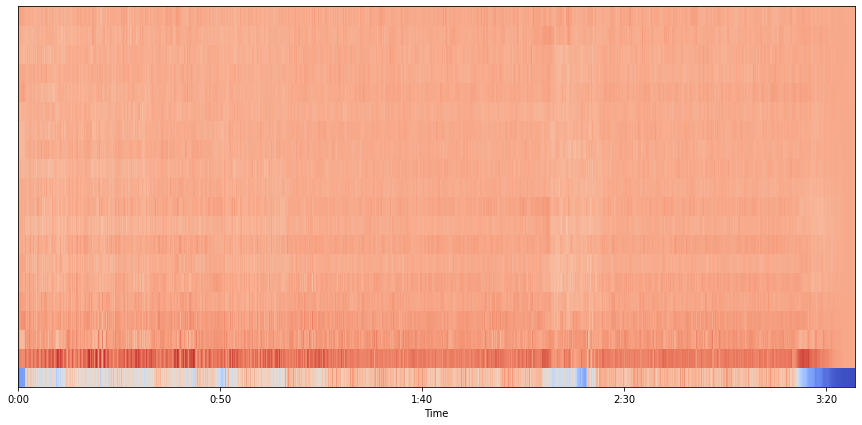

In [30]:
# view a spectrogram for a random mfcc

x, sr = librosa.load('../data/myspace_mp3s/21/acoustic/std_0316c16c7ea854e64d7d20ca9ef88b05.mp3')
x_mfcc = librosa.feature.mfcc(x, sr=sr)

#(20, 8921),
print(x_mfcc.shape, x_mfcc.min(), x_mfcc.max(), x_mfcc.mean(), x_mfcc.std(), x_mfcc[:,:5])

plt.figure(figsize=(15, 7))
librosa.display.specshow(x_mfcc, sr=sr, x_axis='time')

#### Extract melspectrograms and store as images

In [ ]:
def extract_melspectrograms(mp3_path, zip_folders, melspec_features_path, metadata, genre_map):
    genre_cts = {g:0 for g in set(genre_map.values())}
    ttl=0
    
    for zip_folder in zip_folders:
        zip_path = '%s/%s' % (mp3_path, zip_folder)
        
        for genre in os.listdir(zip_path):
            genre_path = '%s/%s' % (zip_path, genre)
            
            for fn in os.listdir(genre_path):
                if not fn.endswith('.mp3'):
                    continue
                    
                fp = '%s/%s' % (genre_path, fn)
                
                zip_num_filename = '%s/%s' % (zip_folder, fn)
                if zip_num_filename not in metadata:
                    continue
                
                meta = metadata[zip_num_filename]
                if not 'genres' in meta or not meta['genres']:
                    continue
                    
                g = [genre_map[g] for g in meta['genres'] if g in genre_map]
                if not g:
                    continue
                    
                use_genre = g[0]
                for gn in g:
                    if g.count(gn)>1:
                        use_genre = gn
                        break
                g = use_genre
                
                #gp = '%s/%s' % (melspec_features_path, g)
                #if not os.path.exists(gp):
                #    print(g)
                #    os.mkdir(gp)

                genre_cts[g]+=1
                    
                ttl+=1
                if ttl%100==0:
                    print('Processed so far: %d' % (ttl))
                
                arr_path = '%s/%s_msp_%s_%s.npy' % (melspec_features_path, g, zip_folder, fn.replace('.mp3', ''))
                if os.path.exists(arr_path):
                    continue
                
                try:
                    x, sr = librosa.load(fp)
                    x_mfcc = librosa.feature.mfcc(x, sr=sr)
                    = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, fmin=20, fmax=16000)
                except Exception as ex:
                    bad_mp3s.append(zip_num_filename)
                    continue
                    
                np.save(arr_path, x_mfcc)
                
    return not_in_metadata, bad_mp3s

In [ ]:
melspec_features_path = '%s/melspec' % features_path
#melspec_features_path = '%s/melspec_new' % features_path
if not os.path.exists(melspec_features_path):
    os.mkdir(melspec_features_path)

zip_folders = [zf for zf in os.listdir(mp3_path) if zf.isdigit()]
#zip_folders = ['82']
    
extract_melspectrograms(myspace_mp3s_path, zip_folders, melspec_features_path, metadata, genre_map)

In [ ]:
#The spectrogram as produced by feature.melspectrogram
#number of FFT components in the resulting STFT
#The hop length of the STFT. If not provided, it will default to n_fft // 4

M = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, fmin=20, fmax=16000)

y = librosa.feature.inverse.mel_to_audio(M, sr=22050, n_fft=2048)

librosa.output.write_wav(path, y, sr, norm=False)

In [ ]:
def extract_genre_features(data, genre, local_mp3s_path, sample_rate=44100, max_mb=5,
                     features=['waveform', 'spectrogram', 'melspectrogram', 'spectral_centroids',
                               'spectral_rolloff', 'spectral_bandwidth_2', 'spectral_bandwidth_3',
                               'spectral_bandwidth_4', 'zero_crossings', 'mfcc', 'chromagram']):
    '''Extracts features from files in genre folder'''
    file_feats = {}
    
    gp = '%s/%s' % (local_mp3s_path, genre)
    for fn in os.listdir(gp):
        if not fn.endswith('.mp3'):
            continue
            
        if not fn in data:
            print('File %s not in metadata!' % fn)
            continue
            
        if 'size_mb' in data[fn] and data[fn]['size_mb'] > max_mb:
            continue

        fp = '%s/%s' % (gp, fn)

        feats = extract_features_from_file(fp, features)

        file_feats[fn] = feats
            
    return file_feats
            
            
def extract_features_from_file(fp, features):
    feats = {}
    x, sr = librosa.load(fp)
    
    if 'spectrogram' in features:
        x_spectrogram = librosa.stft(x)
        x_spectrogram = librosa.amplitude_to_db(abs(x_spectrogram))
        feats['spectrogram'] = x_spectrogram
        
    if 'melspectrogram' in features:
        x_melspectrogram = librosa.feature.melspectrogram(x, sr=sr, n_mels=128, fmin=20, fmax=16000)
        x_melspectrogram = librosa.power_to_db(x_melspectrogram, ref=np.max)
        feats['melspectrogram'] = x_melspectrogram
        
    if 'spectral_centroids' in features:
        #frames len
        x_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
        x_centroids = normalize(spectral_centroids)
        feats['spectral_centroids'] = x_centroids
        
    if 'spectral_rolloff' in features:
        x_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]
        x_rolloff = normalize(spectral_rolloff)
        feats['spectral_rolloff'] = x_rolloff
     
    if 'spectral_bandwidth_2' in features:
        #p = Power to raise deviation from spectral centroid.
        x_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
        feats['spectral_bandwidth_2'] = x_bandwidth_2
        
    if 'spectral_bandwidth_3' in features:
        x_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
        feats['spectral_bandwidth_3'] = x_bandwidth_3
            
    if 'spectral_bandwidth_4' in features:
        x_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]
        feats['spectral_bandwidth_4'] = x_bandwidth_4
        
    if 'zero_crossings' in features:
        x_crossings = librosa.zero_crossings(x, pad=False)
        feats['zero_crossings'] = x_crossings
        
    #Mel-Frequency Cepstral Coefficients (MFCCs)
    if 'mfcc' in features:
        x_mfcc = librosa.feature.mfcc(x, sr=sr)
        feats['mfcc'] = x_mfcc
        
    if 'chromagram' in features:
        hop_length=512
        x_chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
        feats['chromagram'] = x_chromagram
    
    return feats

        
# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)